# 1. Getting the Data.

In [ ]:
from torch import nn
from torchvision import transforms

In [ ]:
import zipfile
import os

# Set the zip file name
zip_file_name = 'test.zip'

# Set the extraction path
extraction_path = '/content/extracted_files'

# Ensure the extraction path exists
os.makedirs(extraction_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print(f"Contents of {zip_file_name} have been extracted to {extraction_path}")

Contents of test.zip have been extracted to /content/extracted_files


In [ ]:
import zipfile
import os

# Set the zip file name
zip_file_name = 'train (3).zip'

# Set the extraction path
extraction_path = '/content/extracted_files'

# Ensure the extraction path exists
os.makedirs(extraction_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print(f"Contents of {zip_file_name} have been extracted to {extraction_path}")

Contents of train (3).zip have been extracted to /content/extracted_files


In [ ]:
from pathlib import Path
import requests
extracted_files_path = Path("extracted_files/")
extracted_files_path

PosixPath('extracted_files')

In [ ]:
train_dir = extracted_files_path/"train"
test_dir = extracted_files_path/"test"

In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4077, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 4077 (delta 24), reused 50 (delta 17), pack-reused 4009 (from 1)
Receiving objects: 100% (4077/4077), 649.09 MiB | 24.91 MiB/s, done.
Resolving deltas: 100% (2377/2377), done.
Updating files: 100% (248/248), done.


# 2. Getting the Pretrained Model.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights = weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 67.1MB/s]


In [ ]:
auto_transform = weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
from going_modular.going_modular import data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir,
                                                                               test_dir,
                                                                               auto_transform,
                                                                               32)

In [ ]:
class_names

['angry', 'happy', 'nothing', 'sad']

Text(0.5, 1.0, 'tensor(0)')

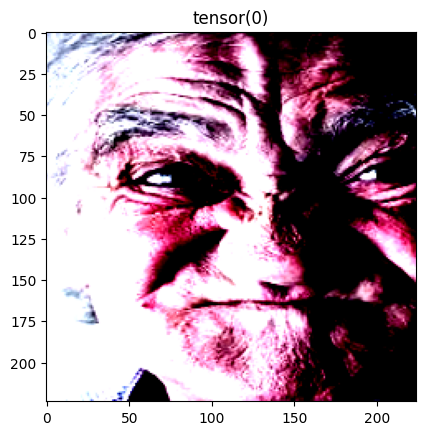

In [ ]:
import matplotlib.pyplot as plt
img, label = next(iter(train_dataloader))
img = img[0].permute(1,2,0)
plt.imshow(img)
plt.title(label[0])

# 3. Training the Model


In [ ]:
from torchinfo import summary
summary(model= model,
        input_size = (1,3,224,224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [ ]:
for params in model.features.parameters():
  params.requires_grad = False


In [ ]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=4, bias=True)
)

In [ ]:
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace = True),
    nn.Linear(in_features = 1280, out_features = len(class_names))
)

In [ ]:
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = 0.005)

loss_fn = nn.CrossEntropyLoss()

In [ ]:
from timeit import default_timer as timer

start_time = timer()

engine.train(model = model,
             train_dataloader = train_dataloader,
             test_dataloader = test_dataloader,
             optimizer = optimizer,
             loss_fn = loss_fn,
             epochs = 5,
             device = device)

end_time = timer()

print(f"Total time taken to train the model {end_time - start_time: .3f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8419 | train_acc: 0.6468 | test_loss: 0.6538 | test_acc: 0.7350
Epoch: 2 | train_loss: 0.6540 | train_acc: 0.7251 | test_loss: 0.6049 | test_acc: 0.7425
Epoch: 3 | train_loss: 0.5989 | train_acc: 0.7528 | test_loss: 0.5795 | test_acc: 0.7567
Epoch: 4 | train_loss: 0.5722 | train_acc: 0.7617 | test_loss: 0.5723 | test_acc: 0.7558
Epoch: 5 | train_loss: 0.5552 | train_acc: 0.7718 | test_loss: 0.5681 | test_acc: 0.7508
Total time taken to train the model  2166.452


In [ ]:
from going_modular.going_modular import utils

utils.save_model(model,
                 target_dir = "models",
                 model_name = "model_1.pth")

[INFO] Saving model to: models/model_1.pth


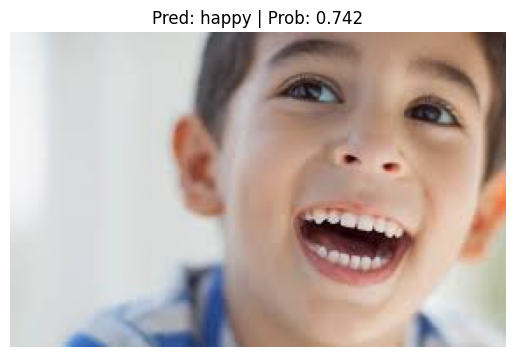

In [ ]:
from going_modular.going_modular import predictions

predictions.pred_and_plot_image(model = model,
                                class_names = class_names,
                                image_path = "/content/images (3).jpeg",
                                transform = auto_transform,
                                device = device)


In [ ]:
from going_modular.going_modular import utils

loaded_model = utils.load_model(
    model_path="models/model_1.pth"
)

In [ ]:
model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
model.fc = torch.nn.Linear(model.fc.in_features, 4)

In [ ]:
model.load_state_dict(torch.load('models/model_1.pth'))

FileNotFoundError: [Errno 2] No such file or directory: 'models/model_1.pth'